In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt
from flask import Flask,jsonify

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, distinct

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)
inspector = inspect(engine)


# Exploratory Climate Analysis

            date  prcp
2225  2017-08-19  0.09
2226  2017-08-20   NaN
2227  2017-08-21  0.56
2228  2017-08-22  0.50
2229  2017-08-23  0.45


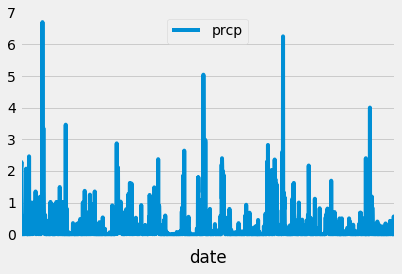

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
session.query(Measurement.date).order_by(Measurement.date.desc()).all()
# Calculate the date 1 year ago from the last data point in the database
last12 = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= '2016-08-23').filter(Measurement.date <= '2017-08-23').all()
last12 = pd.DataFrame(last12)
# print(measurement_df.tail())
print(last12.tail())
# Perform a query to retrieve the data and precipitation scores
precipitation_scores = session.query(Measurement.prcp).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
measurement_df = pd.DataFrame(last12).dropna()


# Sort the dataframe by date
measurement_df = measurement_df.set_index('date').sort_index()
# Use Pandas Plotting with Matplotlib to plot the data
measurement_df.plot(y='prcp')
plt.legend(loc='upper center')
plt.xticks([])
plt.show()

![precipitation](Images/precipitation.png)

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
measurement_df.describe()


,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [14]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(distinct(Measurement.station))).all()

[(9)]

In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281'
                                                                                            ).first()

(54.0, 85.0, 71.66378066378067)

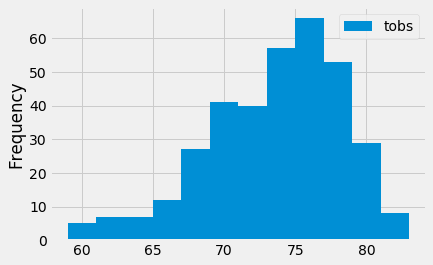

In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tmp12 = session.query(Measurement.date, Measurement.tobs).filter(Measurement.date >= '2016-08-23').filter(Measurement.station == 'USC00519281').all()
tmp12_df = pd.DataFrame(tmp12).set_index('date').sort_index()

tmp12_df.plot(kind='hist',bins=12)
plt.show()

![precipitation](Images/station-histogram.png)

In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [18]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
tmp1 = calc_temps('2011-02-28', '2011-03-05')


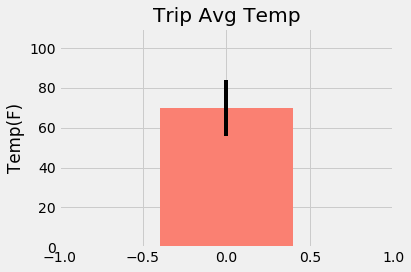

In [58]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
err = tmp1[0][2]-tmp1[0][0]
avgtemp = tmp1[0][1]
min_temp = tmp1[0][0]
max_temp = tmp1[0][2]

fig, ax = plt.subplots()
bar_chart = ax.bar(0 , avgtemp, color= 'salmon', yerr=err)
ax.set_ylabel("Temp(F)")
ax.set_title("Trip Avg Temp")
     
plt.ylim(0, 110)
plt.xlim(-1,1)
fig.tight_layout()
plt.show()

In [19]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rainfallperstation = session.query(Measurement.station,func.sum(Measurement.prcp),Station.name,Station.latitude,Station.longitude, Station.elevation).join(Station,Measurement.station==Station.station).filter(Measurement.date>='2011-02-28').filter(Measurement.date<='2011-03-05').group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()

print(rainfallperstation)



[('USC00518838', 2.33, 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6), ('USC00519281', 2.23, 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9), ('USC00519523', 2.19, 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5), ('USC00514830', 1.96, 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0), ('USC00516128', 1.45, 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4), ('USC00513117', 1.44, 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6), ('USC00519397', 1.38, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0), ('USC00511918', 0.63, 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9), ('USC00517948', None, 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)]


## Optional Challenge Assignment

In [390]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [391]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [34]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


[{'station': 'USC00519397', 'name': 'WAIKIKI 717.2, HI US'}]
[{'station': 'USC00519397', 'name': 'WAIKIKI 717.2, HI US'}, {'station': 'USC00513117', 'name': 'KANEOHE 838.1, HI US'}]
[{'station': 'USC00519397', 'name': 'WAIKIKI 717.2, HI US'}, {'station': 'USC00513117', 'name': 'KANEOHE 838.1, HI US'}, {'station': 'USC00514830', 'name': 'KUALOA RANCH HEADQUARTERS 886.9, HI US'}]
[{'station': 'USC00519397', 'name': 'WAIKIKI 717.2, HI US'}, {'station': 'USC00513117', 'name': 'KANEOHE 838.1, HI US'}, {'station': 'USC00514830', 'name': 'KUALOA RANCH HEADQUARTERS 886.9, HI US'}, {'station': 'USC00517948', 'name': 'PEARL CITY, HI US'}]
[{'station': 'USC00519397', 'name': 'WAIKIKI 717.2, HI US'}, {'station': 'USC00513117', 'name': 'KANEOHE 838.1, HI US'}, {'station': 'USC00514830', 'name': 'KUALOA RANCH HEADQUARTERS 886.9, HI US'}, {'station': 'USC00517948', 'name': 'PEARL CITY, HI US'}, {'station': 'USC00518838', 'name': 'UPPER WAHIAWA 874.3, HI US'}]
[{'station': 'USC00519397', 'name': 'WAIK

SyntaxError: 'return' outside function (<ipython-input-65-5784ffc57197>, line 9)

In [20]:
app = Flask(__name__)

In [22]:
@app.route("/api/v1.0/precipitation")
def precipitation():
    rain = session.query(Measurement.date, Measurement.prcp).order_by(Measurement.date).all()
    rainlist = []
    for result in rain:
        raindict = {}
        raindict["date"] = result[0]
        raindict["prcp"] = result[1]
        rainlist.append(raindict)
    return jsonify(rainlist)



AssertionError: View function mapping is overwriting an existing endpoint function: precipitation

In [23]:
@app.route("/api/v1.0/stations")
def stations():
    station = session.query(Station.station, Station.name)
    stationlist = []
    for ls in station:
        dt = {}
        dt['station'] = ls[0]
        dt['name'] = ls[1]
        stationlist.append(dt)


    return jsonify(stationlist)


In [76]:
@app.route("/api/v1.0/tobs")
def tobs():
    route = session.query(Measurement.date,Measurement.tobs).filter(Measurement.date >= '2016-08-23').order_by(Measurement.date.desc()).all()
    tobslist=[]
    for r in route:
        tobsdict = {}
        tobsdict['date'] = r[0]
        tobsdict['tobs'] = r[1]
        tobslist.append(tobsdict)
    return(jsonify(tobslist))


AssertionError: View function mapping is overwriting an existing endpoint function: tobs

In [37]:
@app.route("/api/v1.0/<start>")

def start_app(start):
    start_date= dt.datetime.strptime(start, '%Y-%m-%d')
    trip_data = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).filter(Measurement.date >= start_date).all()
    trip = list(np.ravel(trip_data))
    return jsonify(trip)

In [43]:
@app.route("/api/v1.0/<start>/<end>")
def start_end_app(start,end):
    start_date= dt.datetime.strptime(start, '%Y-%m-%d')
    end_date= dt.datetime.strptime(end,'%Y-%m-%d')
    trip_data = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
    trip = list(np.ravel(trip_data))
    return jsonify(trip)




[(56.0, 73.8070437076976, 87.0)]


In [59]:
app.run(debug=True)

 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
 * Restarting with stat


SystemExit: 1

/Users/stevenovis/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2870: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
